In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import cv2
from joblib import Parallel, delayed
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

# Data Loading

In [2]:
t0=time.time()

calx = np.arange(800,1801)
data = np.loadtxt(r"/root/raman clustering data/1-JZ_hres_CAL-NORM-BS-BFG-data_background_filtered.txt")
data = np.transpose(data)
rows = 111
cols = 451

reshaped_data = np.zeros((data.shape[0], rows, cols))

for i in range(data.shape[0]):  # Loop over all spectra
    linear_data = data[i]  # Get the i-th spectrum as a flat array
    reshaped = linear_data[:rows * cols].reshape(rows, cols)  # Reshape to rows and columns
    
    # Apply zigzag pattern: reverse every other row (Because the data are taken as raster scan)
    for r in range(rows):
        if r % 2 == 1:  # Odd rows are reversed
            reshaped[r] = reshaped[r][::-1]
    
    reshaped_data[i] = reshaped  # Store the zigzag reshaped data
reshaped_data = reshaped_data.transpose(1,2,0)
print(calx.shape)
print(reshaped_data.shape)

t1=time.time()
t1-t0

(1001,)
(111, 451, 1001)


3.1264452934265137

In [3]:
n_samples, n_features, n_bands = reshaped_data.shape

# UMAP Component Analysis

In [4]:
flattened_data = reshaped_data.reshape(-1,n_bands)
nan_mask = np.isnan(flattened_data)
non_nan_data = flattened_data[~nan_mask].reshape(-1,n_bands)
scaler = StandardScaler()
reshaped_data_scaled = scaler.fit_transform(non_nan_data)

In [5]:
reshaped_data_scaled.shape

(48765, 1001)

In [6]:
t0=time.time()

umap_reducer = umap.UMAP(metric="cosine", random_state=42, n_components=2, n_jobs=-1)
X_umap = umap_reducer.fit_transform(reshaped_data_scaled)

t1=time.time()
t1-t0

/home/root/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


59.20457124710083

In [7]:
umap_with_nans = np.full((flattened_data.shape[0], 2), np.nan)
umap_valid_rows = ~np.any(nan_mask, axis=1)
umap_with_nans[umap_valid_rows] = X_umap

In [8]:
umap_with_nans.shape

(50061, 2)

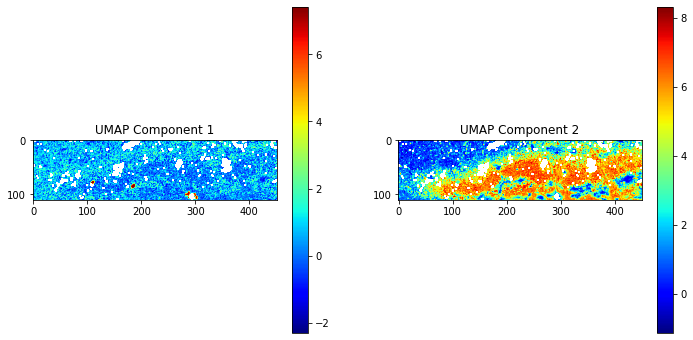

In [9]:
umap_reshaped = umap_with_nans.reshape(n_samples, n_features, 2)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(umap_reshaped[:, :, 0], cmap='jet')
plt.colorbar()
plt.title("UMAP Component 1")

plt.subplot(1, 2, 2)
plt.imshow(umap_reshaped[:, :, 1], cmap='jet')
plt.colorbar()
plt.title("UMAP Component 2")

plt.show()

# UMAP Dimension Visualization

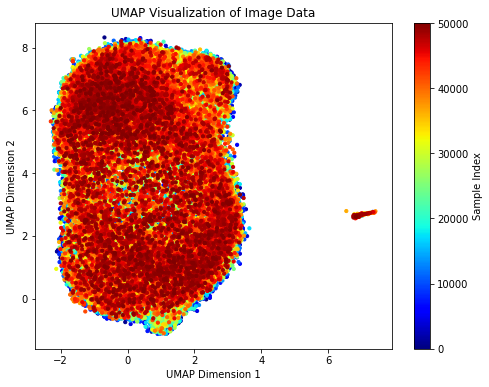

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_with_nans[:, 0], umap_with_nans[:, 1], c=np.arange(rows*cols), cmap='jet', s=10)
plt.colorbar(label='Sample Index')
plt.title("UMAP Visualization of Image Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# Finding the best eps for clustering

In [11]:
min_samples = int(rows*cols/20)

In [12]:
eps_values = np.arange(0.0, 2.0, 0.1)

def evaluate_optics(eps, X_umap, min_samples):
    optics = OPTICS(min_samples=min_samples, max_eps=eps, n_jobs=-1)
    clusters = optics.fit(X_umap)
    
    labels = clusters.labels_
    n_clusters = len(set(labels) - {-1})
    
    if n_clusters > 1:
        score = silhouette_score(X_umap, labels, sample_size=min(len(X_umap), int(rows * cols / 10)))
    else:
        score = -1
    return score

In [13]:
t0=time.time()

silhouette_scores = Parallel(n_jobs=-1)(delayed(evaluate_optics)(eps, X_umap, min_samples) for eps in eps_values)

t1=time.time()
print(t1-t0)
best_eps = eps_values[np.argmax(silhouette_scores)]
best_eps

931.2393946647644


1.0

In [14]:
silhouette_scores

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.3063463,
 0.38526753,
 0.36569867,
 0.42745957,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [15]:
eps_values_new = np.arange(best_eps - 0.1, best_eps + 0.1, 0.01)

In [16]:
t0=time.time()

silhouette_scores_new = Parallel(n_jobs=-1)(delayed(evaluate_optics)(eps, X_umap, min_samples) for eps in eps_values_new)

t1=time.time()
print(t1-t0)
best_eps_new = eps_values_new[np.argmax(silhouette_scores_new)]
best_eps_new

1191.1274864673615


1.06

In [17]:
silhouette_scores_new

[0.3600038,
 0.37105224,
 0.37707648,
 0.36706698,
 0.3517582,
 0.37922004,
 0.37654263,
 0.40273336,
 0.43906122,
 0.43632337,
 0.45140895,
 0.4686614,
 0.49858734,
 0.50734794,
 0.51287186,
 0.5262762,
 0.5270191,
 -1,
 -1,
 -1,
 -1]

# Clustering by OPTICS

In [18]:
t0=time.time()
optics = OPTICS(min_samples=min_samples, max_eps=best_eps_new, n_jobs=-1)
clusters_new = optics.fit(X_umap)

labels = optics.labels_
t1=time.time()
t1-t0

496.89895701408386

In [19]:
clusters_new.labels_.shape

(48765,)

In [20]:
cluster_with_nans = np.full((flattened_data.shape[0]), np.nan)
cluster_valid_rows = ~np.any(nan_mask, axis=1)
cluster_with_nans[umap_valid_rows] = clusters_new.labels_

In [21]:
cluster_with_nans_reshaped = cluster_with_nans.reshape(rows,cols)

# Cluster Comparison

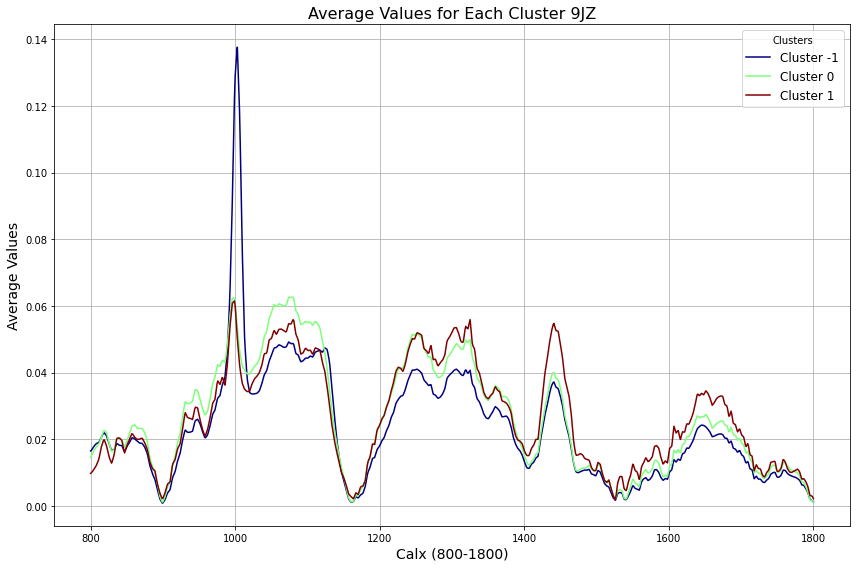

In [22]:
cluster_averages = {}

unique_clusters = np.unique(cluster_with_nans_reshaped)
unique_clusters = unique_clusters[~np.isnan(unique_clusters)]  # Remove NaN

for cluster in unique_clusters:
    cluster_mask = cluster_with_nans_reshaped == cluster
    
    cluster_data = reshaped_data[cluster_mask]
    
    cluster_average = np.mean(cluster_data, axis=0)  # Shape: (1001,)
    
    cluster_averages[int(cluster)] = cluster_average

plt.figure(figsize=(12, 8))

colormap = plt.cm.jet
colors = colormap(np.linspace(0, 1, len(unique_clusters)))

for idx, (cluster, avg_values) in enumerate(cluster_averages.items()):
    plt.plot(calx, avg_values, label=f"Cluster {cluster}", color=colors[idx])

plt.title("Average Values for Each Cluster 9JZ", fontsize=16) # Must be 1JZ, it is a typo.
plt.xlabel("Calx (800-1800)", fontsize=14)
plt.ylabel("Average Values", fontsize=14)
plt.legend(title="Clusters", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# OPTICS Results

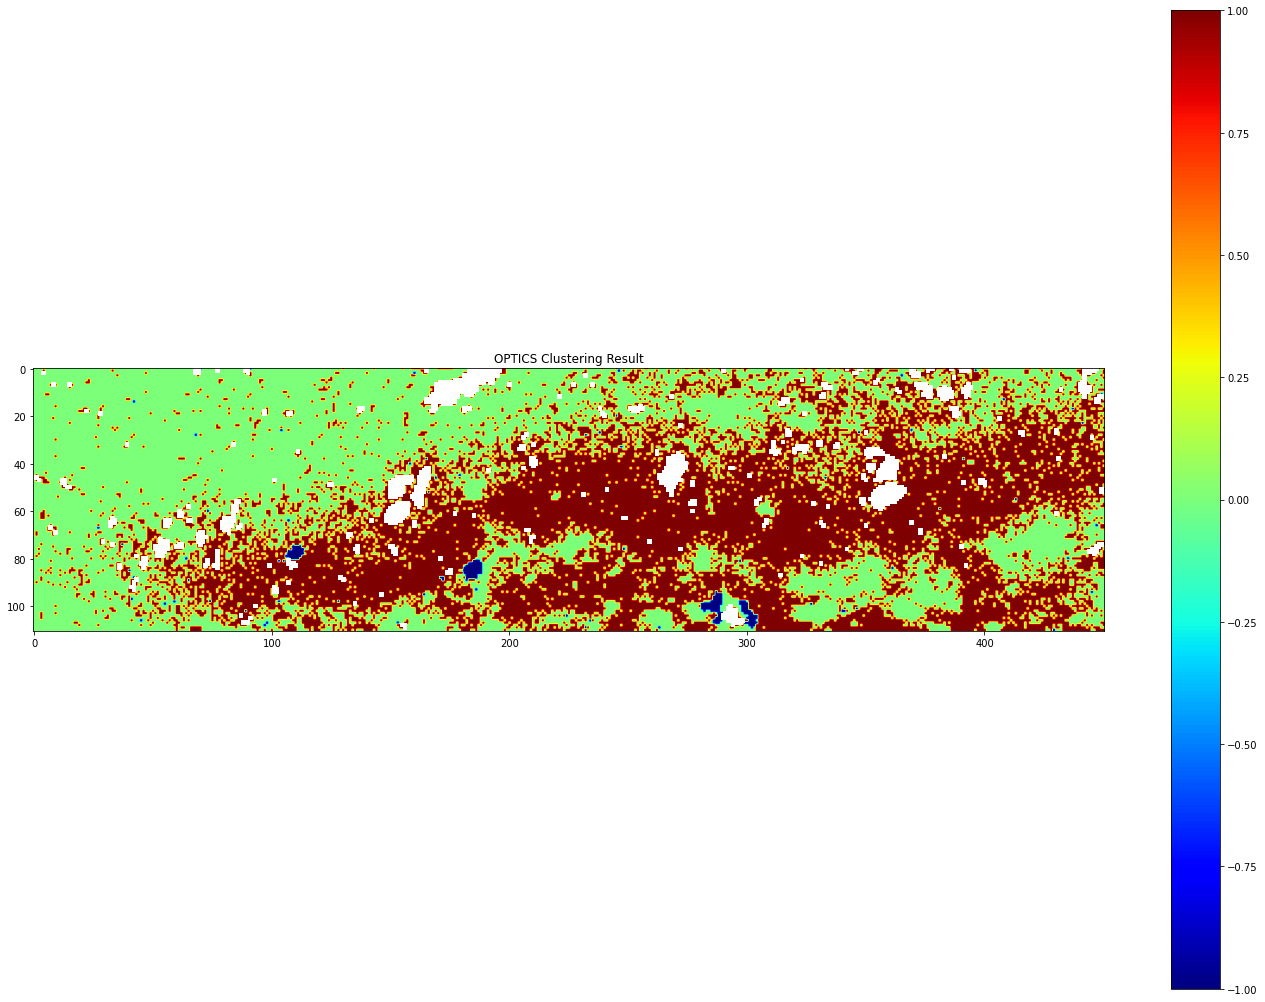

In [23]:
plt.figure(figsize=(24, 18))
plt.imshow(cluster_with_nans_reshaped, cmap='jet')
plt.colorbar()
plt.title("OPTICS Clustering Result")
plt.show()

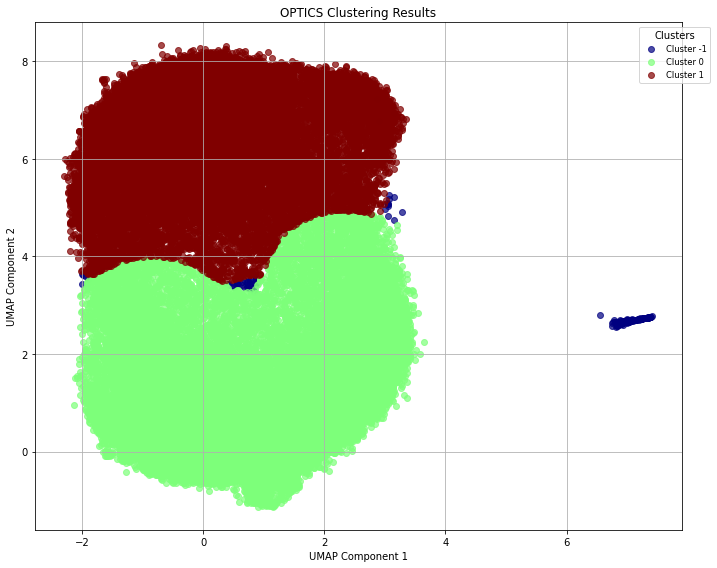

In [24]:
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)

# Use the `jet` colormap
colormap = plt.cm.jet
colors = colormap(np.linspace(0, 1, len(unique_labels)))

for idx, label in enumerate(unique_labels):
    color = colors[idx]  
    marker = 'o' 
    label_name = f'Cluster {label}'
    
    mask = labels == label
    plt.scatter(
        X_umap[mask, 0],
        X_umap[mask, 1],
        c=[color],  
        label=label_name,
        marker=marker,
        alpha=0.7,
    )

plt.title("OPTICS Clustering Results")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(loc='best', title="Clusters", bbox_to_anchor=(1.05, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()